## An example of CHAOS-6 Core, Static and MMA models evaluation

In [1]:
# load data from VirES server
from eoxmagmod.data import CHAOS6_CORE_LATEST as CUSTOM_SHC_FILE
from viresclient import SwarmRequest

request = SwarmRequest("https://staging.viresdisc.vires.services/openows")
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=[
        'B_NEC',
    ],
    models = [
        #'CHAOS-6-Core',
        #'CHAOS-6-Static',
        'CHAOS-6-Combined',
        'CHAOS-6-MMA-Primary',
        'CHAOS-6-MMA-Secondary',
    ],
    auxiliaries=['QDLat', 'MLT'],
    sampling_step="PT1S",
)
data = request.get_between(
    start_time="2014-01-01T00:00:00Z",
    end_time="2014-01-02T00:00:00Z"
).as_xarray()
print(data)

/usr/local/conda/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:1209: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class CDF(collections.MutableMapping):
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Can't download new leap second table
Can't find leap second table.  Using one built into code.
Last leap second in built in table is on Jan 01 2017. 


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:51, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (12.535MB)


<xarray.Dataset>
Dimensions:                      (Timestamp: 86400, dim: 3)
Coordinates:
  * Timestamp                    (Timestamp) datetime64[ns] 2014-01-01 ... 2014-01-01T23:59:59
Dimensions without coordinates: dim
Data variables:
    Spacecraft                   (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                     (Timestamp) float64 -1.229 -1.292 ... -82.0
    Longitude                    (Timestamp) float64 -14.12 -14.12 ... 2.21
    Radius                       (Timestamp) float64 6.878e+06 ... 6.88e+06
    B_NEC                        (Timestamp, dim) float64 2.01e+04 ... -3.614e+04
    B_NEC_CHAOS-6-Combined       (Timestamp, dim) float64 2.011e+04 ... -3.614e+04
    B_NEC_CHAOS-6-MMA-Primary    (Timestamp, dim) float64 -11.93 2.118 ... -29.0
    B_NEC_CHAOS-6-MMA-Secondary  (Timestamp, dim) float64 1.019 ... 6.773
    QDLat                        (Timestamp) float64 -11.99 -12.05 ... -69.95
    MLT                          (Timestamp) float64 22

In [2]:
# extract times, coordinates and other data

from numpy import asarray, datetime64, stack


NS2DAYS = 1.0/(24*60*60*1e9) # nano seconds to days scale factor

# time as MJD2000
times = (
    asarray(data["Timestamp"], dtype="M8[ns]") - datetime64('2000')
).astype('int64') * NS2DAYS

# spherical coordinates
coords = stack((
    data["Latitude"].values, # latitude in deg
    data["Longitude"].values, # latitude in deg
    data["Radius"].values*1e-3, # radius in km
), axis=1)

# measurements
b_nec_measured = data["B_NEC"].values

# model values
b_nec_model = (
    #data["B_NEC_CHAOS-6-Core"].values +
    #data["B_NEC_CHAOS-6-Static"].values +
    data["B_NEC_CHAOS-6-Combined"].values +
    data["B_NEC_CHAOS-6-MMA-Primary"].values +
    data["B_NEC_CHAOS-6-MMA-Secondary"].values
)
b_nec_model_no_mma = (
    #data["B_NEC_CHAOS-6-Core"].values +
    #data["B_NEC_CHAOS-6-Static"].values +
    data["B_NEC_CHAOS-6-Combined"].values
 
)

# quasi-dipole latitudes
qdlats = data["QDLat"].values

# magnetic local time
mlt = data['MLT'].values

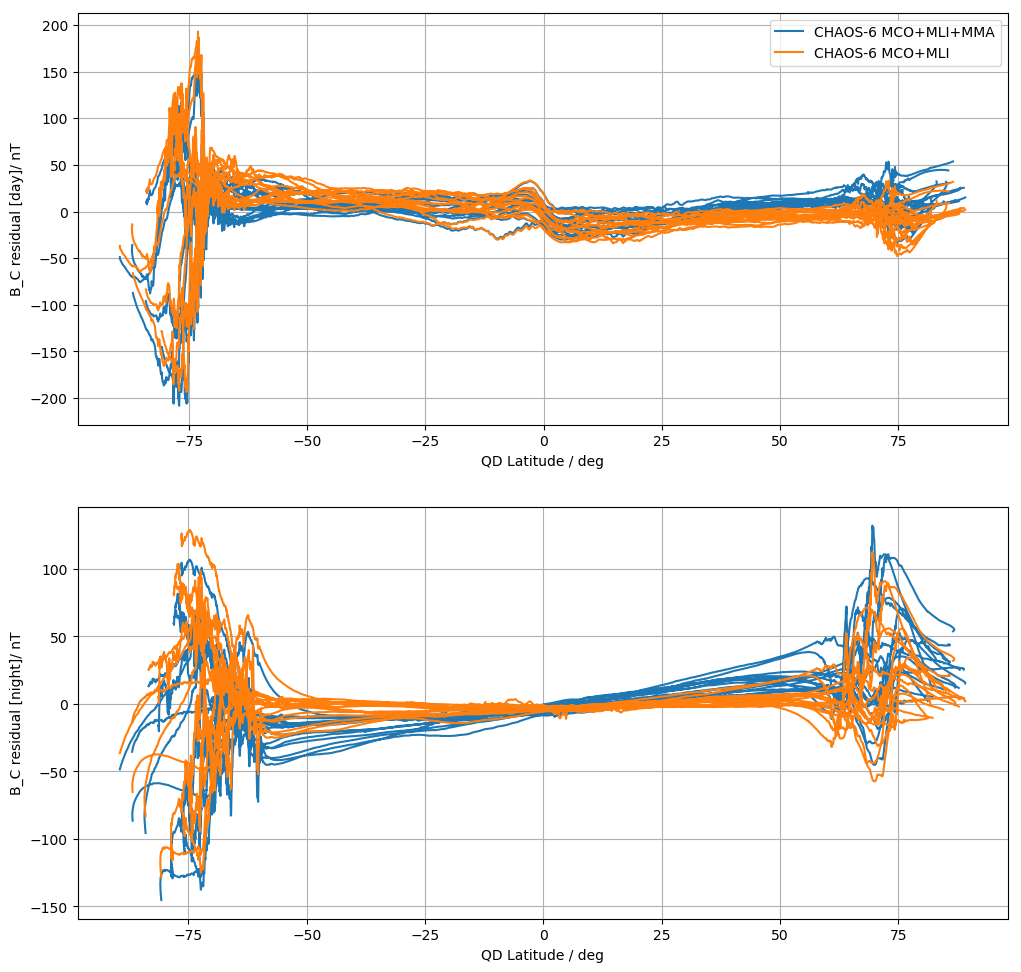

In [4]:
# display residuals

from matplotlib.pyplot import figure, subplot, show
from numpy.ma import masked_where, array as masked_array

b_nec_res = masked_array(b_nec_measured - b_nec_model)
b_nec_res_no_mma = masked_array(b_nec_measured - b_nec_model_no_mma)


fig = figure(figsize=(12, 12), dpi=100)

ax = subplot(211)
mask = (mlt < 6) | (mlt > 18)
ax.plot(qdlats, masked_where(mask, b_nec_res_no_mma[..., 2]), label='CHAOS-6 MCO+MLI+MMA')
ax.plot(qdlats, masked_where(mask, b_nec_res[..., 2]), label='CHAOS-6 MCO+MLI')
ax.legend()
ax.grid()
ax.set_xlabel('QD Latitude / deg')
ax.set_ylabel('B_C residual [day]/ nT')


ax = subplot(212)
mask = (mlt >= 6) & (mlt <= 18)
ax.plot(qdlats, masked_where(mask, b_nec_res_no_mma[..., 2]), label='CHAOS-6 MCO+MLI+MMA')
ax.plot(qdlats, masked_where(mask, b_nec_res[..., 2]), label='CHAOS-6 MCO+MLI')
ax.grid()
ax.set_xlabel('QD Latitude / deg')
ax.set_ylabel('B_C residual [night]/ nT')


show()